# Импорт библиотек

In [ ]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 8.5 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762836 sha256=ad6354665e4e4c25323666e788338746ab6b0814c27cc9a6251ffbc3dd11baa4
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy


In [ ]:
from google.colab import auth, drive
from googleapiclient.discovery import build

auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image, ImageOps
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, cm

from medpy.metric import dc, jc
from medpy.io import load, header

import nibabel as nib

from sklearn.model_selection import train_test_split as tts
from tqdm import notebook, trange

SEED = 42

# Загрузка и буфферизация изображений

Я перебрал несколько датасетов с Kaggle и Zenodo, но все они в других форматах. Выбрал один - https://zenodo.org/records/8179129. Переведем его в формат датасета, на котором изначально обучалась модель


In [ ]:
def path(fname, num):
    return f'drive/My Drive/nifti/' + fname

def get_data(num):
    X_path = path('', num)
    X_filenames = []
    y_filenames = []

    for directory in notebook.tqdm(os.listdir(X_path)[:-1], position=0):
        for dirName, subdirList, fileList in os.walk(X_path+directory):
            for filename in fileList:
                if "pv.nii.gz" == filename.lower():
                    X_filenames.append(os.path.join(dirName, filename))
                if "rater1_liver.nii.gz" == filename.lower():
                    y_filenames.append(os.path.join(dirName, filename))
    assert len(X_filenames) == len(y_filenames)
    return sorted(X_filenames), sorted(y_filenames)

In [ ]:
X_filenames1, y_filenames1 = get_data(1)

X_filenames = X_filenames1
y_filenames = y_filenames1

print(len(X_filenames), len(y_filenames))

  0%|          | 0/17 [00:00<?, ?it/s]

16 16


In [ ]:
def buffer_imgs(filenames, is_dicom, folder='buffer'):
    files = []
    if not os.path.exists(folder):
        os.makedirs(folder)

    for filename in notebook.tqdm(filenames, desc="Processing files"):
        # Загрузка данных из .nii.gz
        img = nib.load(filename).get_fdata()

        # Нормализация данных (для КТ снимков)
        if is_dicom:
            img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255  # Масштабирование в диапазон [0, 255]
            img = img.astype(np.uint8)
        else:
            img = img.astype(np.uint8)

        # Обработка каждого среза
        for i in range(img.shape[2]):  # по оси Z (срезам)
            slice_2d = img[:, :, i]
            pil_img = Image.fromarray(slice_2d)
            pil_img = ImageOps.pad(pil_img, (512, 512), method=0, color=0)
            pil_img = pil_img.rotate(180)
            fname = os.path.join(folder, f"{os.path.basename(filename).replace('/', '-')}_slice_{i:03d}")

            if is_dicom:
                fname = fname + '.tiff'
                pil_img.save(fname, 'TIFF', compression='none')
            else:
                fname = fname + '.png'
                pil_img.save(fname, 'PNG', compression='none')

            files.append(fname)

    return pd.DataFrame(files)


In [ ]:
X = buffer_imgs(X_filenames, is_dicom=True, folder='buffer/X')
y = buffer_imgs(y_filenames, is_dicom=False, folder='buffer/y')

Processing files:   0%|          | 0/16 [00:00<?, ?it/s]

Processing files:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
y

0
0     buffer/y/rater1_liver.nii.gz_slice_000.png
1     buffer/y/rater1_liver.nii.gz_slice_001.png
2     buffer/y/rater1_liver.nii.gz_slice_002.png
3     buffer/y/rater1_liver.nii.gz_slice_003.png
4     buffer/y/rater1_liver.nii.gz_slice_004.png
...                                          ...
1293  buffer/y/rater1_liver.nii.gz_slice_115.png
1294  buffer/y/rater1_liver.nii.gz_slice_116.png
1295  buffer/y/rater1_liver.nii.gz_slice_117.png
1296  buffer/y/rater1_liver.nii.gz_slice_118.png
1297  buffer/y/rater1_liver.nii.gz_slice_119.png

[1298 rows x 1 columns]

Рассмотрим несколько изображений с наложением маски

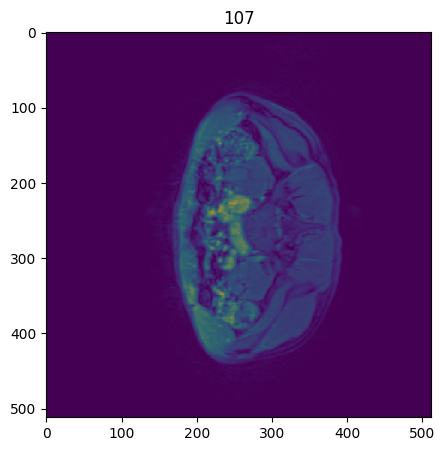

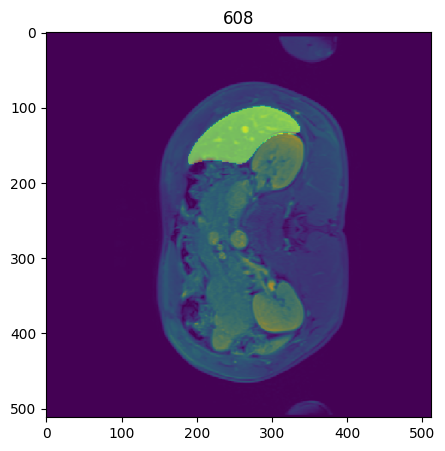

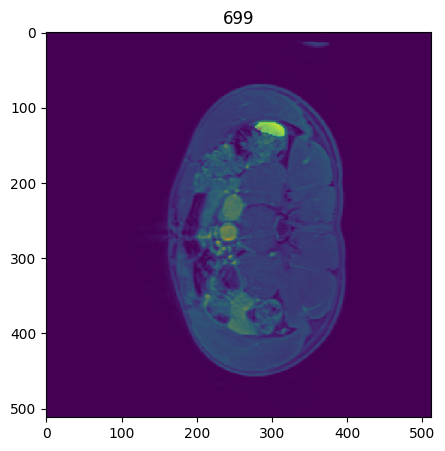

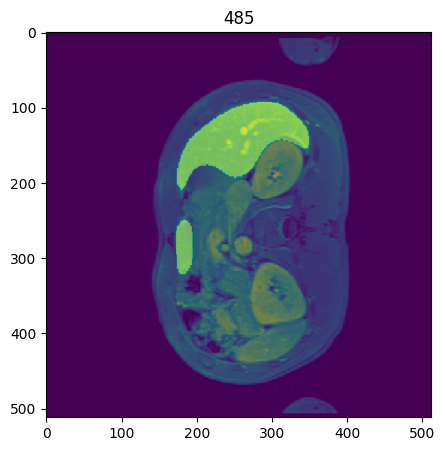

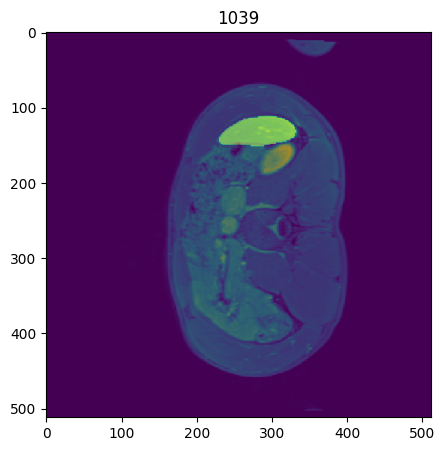

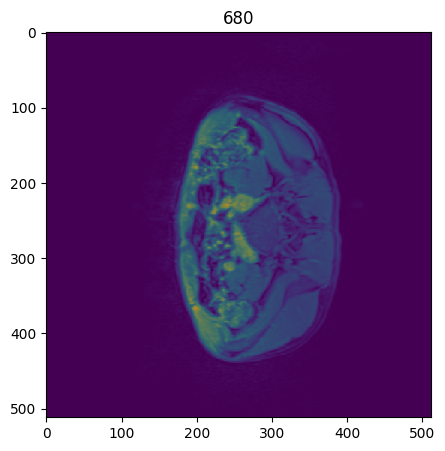

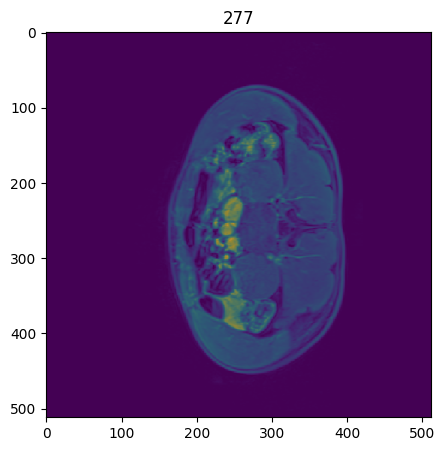

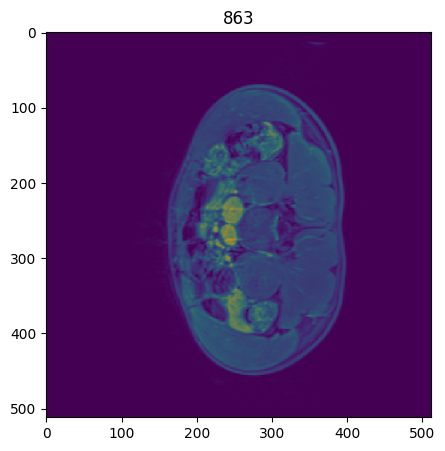

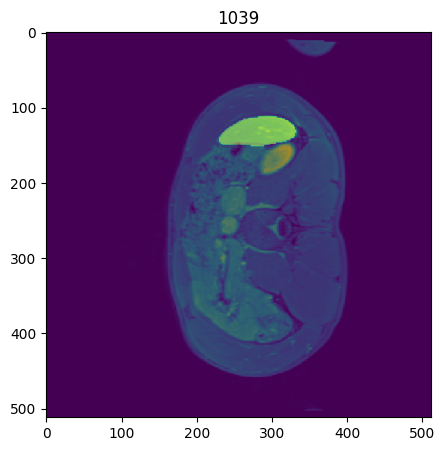

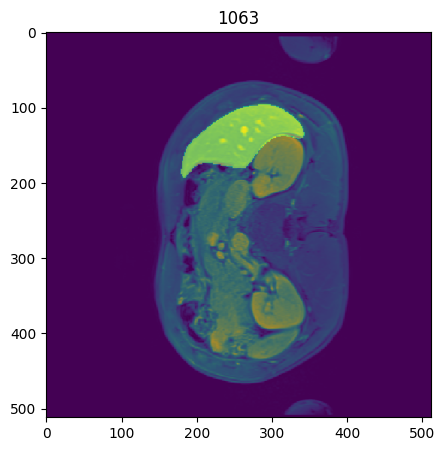

In [ ]:
def show_img(n):
    plt.figure(figsize=(5,5))
    plt.imshow(Image.open(X[0][n]))
    plt.imshow(Image.open(y[0][n]), alpha=0.4)
    plt.title(n)

for i in np.random.choice(np.arange(y.shape[0]), 10):
    show_img(i)

# Обучение модели

Разделим данные на тренировочную и тестовую выборки в отношении 70/30. Из тренировочной возмем 10% для валидации

In [ ]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, shuffle=True, random_state=SEED)
X_tr, X_val, y_tr, y_val = tts(X_train, y_train, test_size=0.1, shuffle=True, random_state=SEED)

Функция, строящая график дообучения

In [ ]:
def plot_history(history, scoring='dice_coef'):
    dct = history.history
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(dct['loss'], label='loss')
    ax[0].plot(dct['val_loss'], label='val_loss')
    ax[1].plot(dct[scoring], label=scoring)
    ax[1].plot(dct[f'val_{scoring}'], label=f'val_{scoring}')
    if 'lr' in dct:
        ax[2].plot(dct['lr'], label='lr')
    [a.legend() for a in ax]

unet1 - код сегментационной нейронной сети U-Net

---


dice_coef - Коэффициент Dice для оценки схожести предсказанных и истинных масок. Он используется как метрика.

---


dice_coef_loss - Функция потерь, основанная на Dice. Минимизируется, чтобы улучшить точность сегментации.

---


jaccard_coef - Коэффициент Жаккара, также используемый для измерения схожести.

---


jaccard_coef_loss - Функция потерь, обратная коэффициенту Жаккара.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU, PReLU, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping


K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    union = K.sum(y_true_f + y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)

def unet_1(img_channels, image_rows, image_cols, neurons=16):
    inputs = Input((img_channels, image_rows, image_cols))

    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    up6 = Dropout(0.5)(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    up7 = Dropout(0.5)(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    up8 = Dropout(0.5)(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    up9 = Dropout(0.5)(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Dropout(0.5)(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


Создадим модель и загрузим веса, имеющейся модели. Заморозим часть слоев, чтобы сохранить ранее накопленные знания и снизить риск переобучения

In [ ]:
from tensorflow.keras.models import load_model

# model = load_model('unet_r(2).h5', compile=False)
w_size = np.array(Image.open(X[0][0])).shape[0]
model = unet_1(1, w_size, w_size, neurons=8)
model.load_weights('unet_r.h5')

# Заморозим все слои до `conv5`
for layer in model.layers:
    if 'conv5' in layer.name or layer.name.startswith('up') or layer.name.startswith('conv10'):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef])

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 1, 512, 512)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 8, 512, 512)    │             80 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)       │ (None, 8, 512, 512)    │            584 │ conv2d_285[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 8, 512, 512)    │          2,048 │ conv2d_286[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_60          │ (None, 8, 256, 256)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_135 (Dropout)     │ (None, 8, 256, 256)    │              0 │ max_pooling2d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_287 (Conv2D)       │ (None, 16, 256, 256)   │          1,168 │ dropout_135[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_288 (Conv2D)       │ (None, 16, 256, 256)   │          2,320 │ conv2d_287[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 16, 256, 256)   │          1,024 │ conv2d_288[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_61          │ (None, 16, 128, 128)   │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_136 (Dropout)     │ (None, 16, 128, 128)   │              0 │ max_pooling2d_61[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_289 (Conv2D)       │ (None, 32, 128, 128)   │          4,640 │ dropout_136[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_290 (Conv2D)       │ (None, 32, 128, 128)   │          9,248 │ conv2d_289[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 32, 128, 128)   │            512 │ conv2d_290[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_62          │ (None, 32, 64, 64)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_137 (Dropout)     │ (None, 32, 64, 64)     │              0 │ max_pooling2d_62[0][0] │
├──────────────────────

 Total params: 494,833 (1.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 494,833 (1.89 MB)

Подготовка данных и обучение модели

In [ ]:
%%time
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stop = EarlyStopping(patience=30)

gen_train_params = {
    'rotation_range': 10,
    'fill_mode':'reflect',
}

idg_train_data = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    **gen_train_params,
)
idg_train_mask = ImageDataGenerator(
    rescale=1./255,
    **gen_train_params
)
idg_test_data = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)
idg_test_mask = ImageDataGenerator(rescale=1./255)

train_gen_params = {
    'x_col': 0,
    'target_size': (512, 512),
    'color_mode': 'grayscale',
    'batch_size': 4,
    'class_mode': None,
    'shuffle': True,
    'seed': SEED,
}
val_gen_params = train_gen_params.copy()
val_gen_params['shuffle'] = False
val_gen_params['batch_size'] = 1

data_train_generator = idg_train_data.flow_from_dataframe(X_tr, **train_gen_params)
mask_train_generator = idg_train_mask.flow_from_dataframe(y_tr, **train_gen_params)

data_test_generator = idg_test_data.flow_from_dataframe(X_val,**val_gen_params)
mask_test_generator = idg_test_mask.flow_from_dataframe(y_val, **val_gen_params)


def custom_generator(data_gen, mask_gen):
    for data, mask in zip(data_gen, mask_gen):
        yield data, mask


train_generator = custom_generator(data_train_generator, mask_train_generator)
test_generator = custom_generator(data_test_generator, mask_test_generator)


history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(data_train_generator),
    validation_steps=len(data_test_generator),
    verbose=1,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Found 817 validated image filenames.
Found 817 validated image filenames.
Found 91 validated image filenames.
Found 91 validated image filenames.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


205/205 ━━━━━━━━━━━━━━━━━━━━ 46s 200ms/step - dice_coef: 5.3392e-04 - loss: 0.9995 - val_dice_coef: 0.1624 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - dice_coef: 4.7960e-04 - loss: 0.9995 - val_dice_coef: 0.1624 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - dice_coef: 5.2632e-04 - loss: 0.9995 - val_dice_coef: 0.1624 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 35s 173ms/step - dice_coef: 6.0976e-04 - loss: 0.9994 - val_dice_coef: 0.1624 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - dice_coef: 4.8965e-04 - loss: 0.9995 - val_dice_coef: 0.1624 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 34s 169ms/step - dice_coef: 5.4511e-04 - loss: 0.9995 - val_dice_coef: 0.1624 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 34s 1

Рассмортим графики обучения

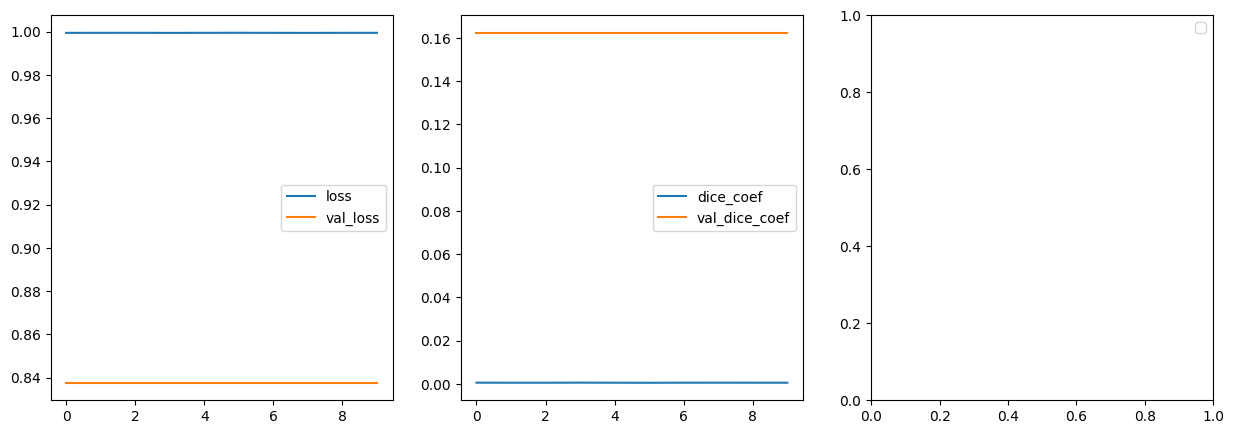

In [ ]:
plot_history(history)

Сохраним модель

In [ ]:
from google.colab import files

name = 'unet_new.h5'
model.save(name)

files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Тест модели

Результаты оказались неудовлетворительными.
Работа над дообучением модели продолжается.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import cv2

def evaluate(x_names, y_names, set_name='evaluating', plot_pairs=0):
    val_gen_params['batch_size'] = 1
    print(set_name)
    dices = []
    jccrs = []

    data_g = idg_test_data.flow_from_dataframe(x_names, **val_gen_params)
    mask_g = idg_test_mask.flow_from_dataframe(y_names, **val_gen_params)

    for i, (image, mask) in enumerate(zip(data_g, mask_g)):
        if i >= len(x_names):
            break
        if mask.max() == 0:
            continue

        p = model.predict(image).astype('uint8')
        dice = dc(p, mask)
        dices.append(dice)

        try:
            jccr = jc(p, mask)
        except ZeroDivisionError:
            jccr = 1
        jccrs.append(jccr)

        if plot_pairs > 0:
            plot_pairs -= 1

            mask_8uc1 = (mask.squeeze() * 255).astype(np.uint8)
            pred_8uc1 = (p.squeeze() * 255).astype(np.uint8)

            contours_true, _ = cv2.findContours(mask_8uc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours_pred, _ = cv2.findContours(pred_8uc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.imshow(image.squeeze(), cmap='gray')
            ax1.imshow(mask.squeeze(), alpha=0.5, cmap='autumn')
            for contour in contours_true:
                ax1.plot(contour[:, 0, 0], contour[:, 0, 1], 'b', linewidth=2)
            ax1.set_title('Истинная маска')

            ax2.imshow(image.squeeze(), cmap='gray')
            ax2.imshow(p.squeeze(), alpha=0.5, cmap='autumn')
            for contour in contours_pred:
                ax2.plot(contour[:, 0, 0], contour[:, 0, 1], 'r', linewidth=2)
            ax2.set_title(f'Предсказанная, Dice={dice:.2f}')
            plt.show()

    mean_dice = np.mean(dices)
    mean_jccr = np.mean(jccrs)

    print('Средний Dice:', mean_dice)
    print('Средний Jaccard:', mean_jccr)
    print('-------------')

    return mean_dice, mean_jccr

TEST SET
Found 390 validated image filenames.
Found 390 validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


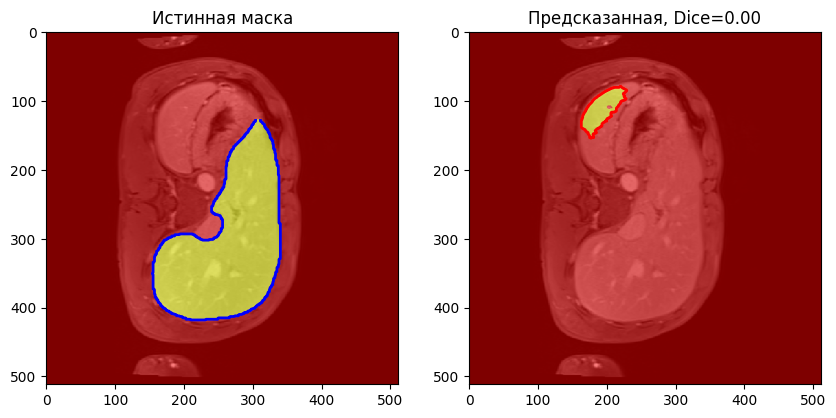

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


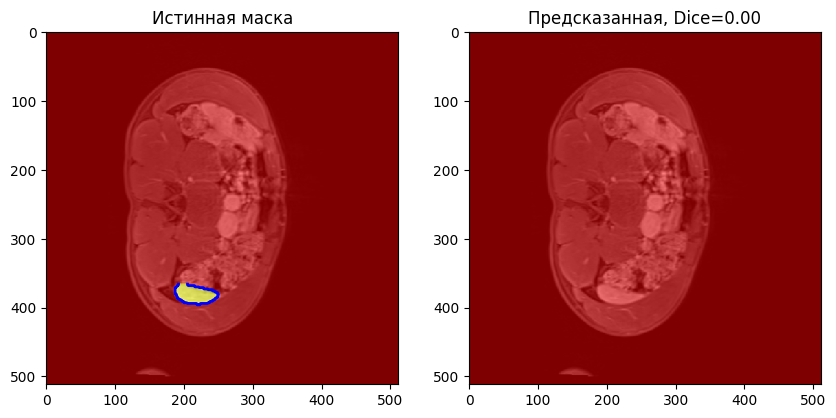

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


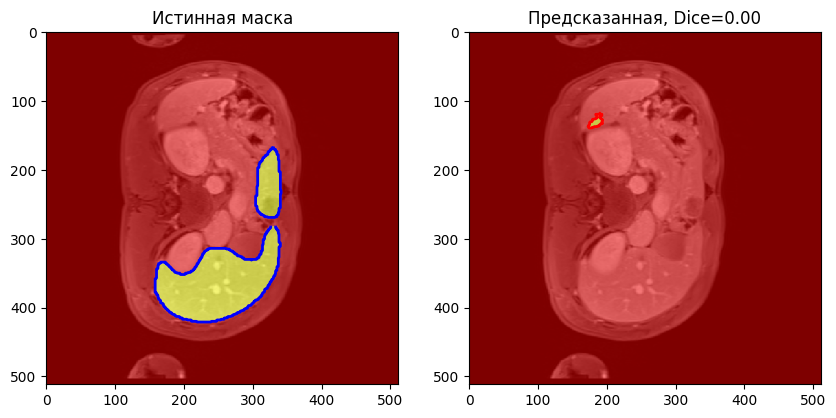

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


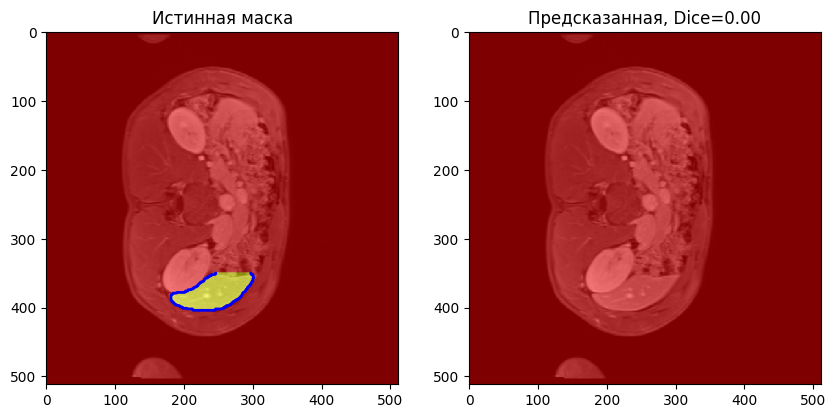

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


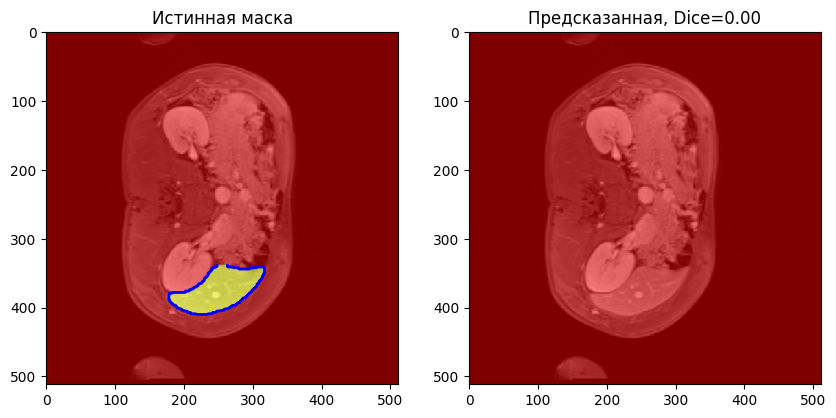

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


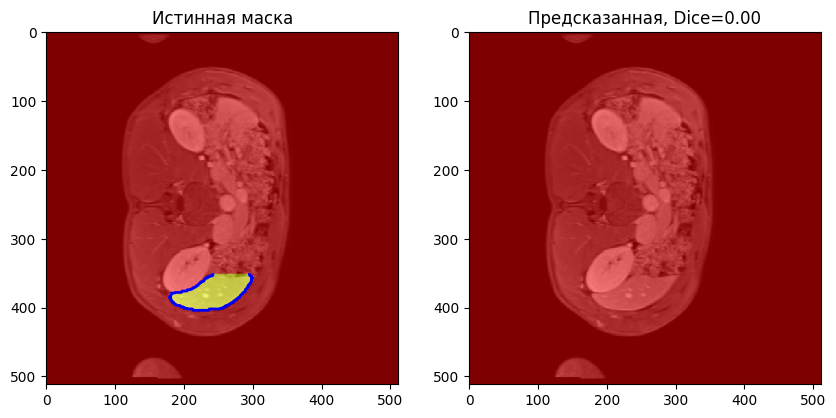

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


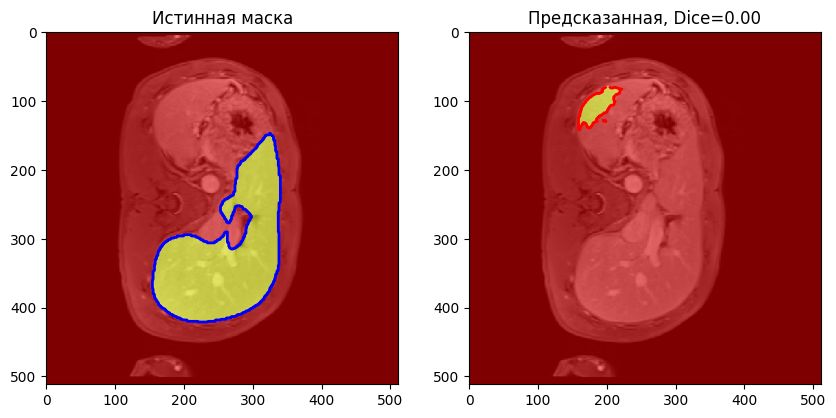

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


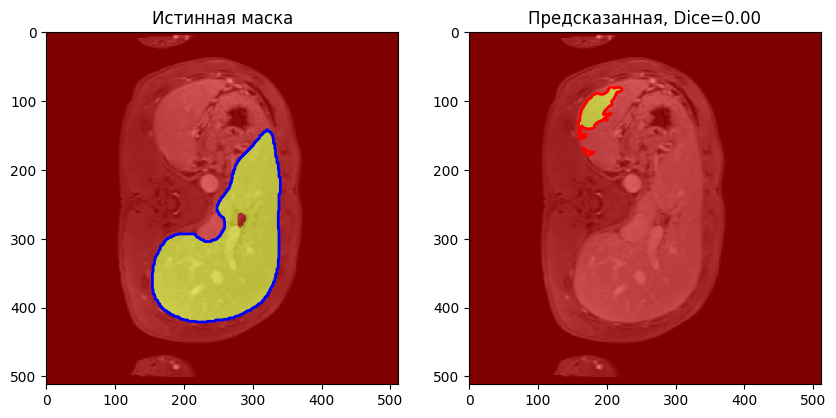

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


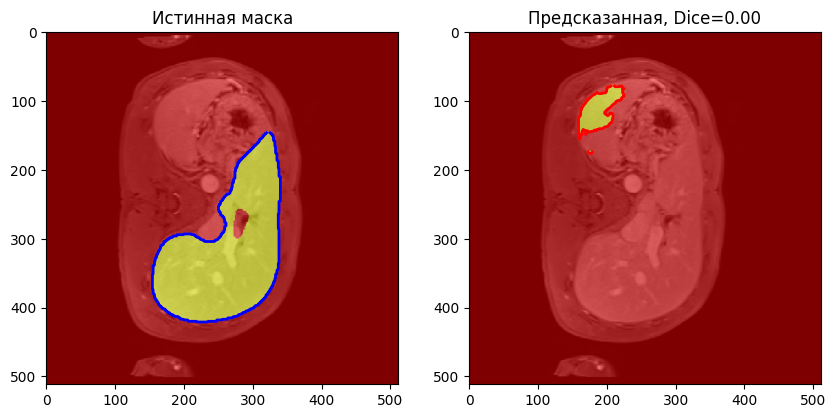

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


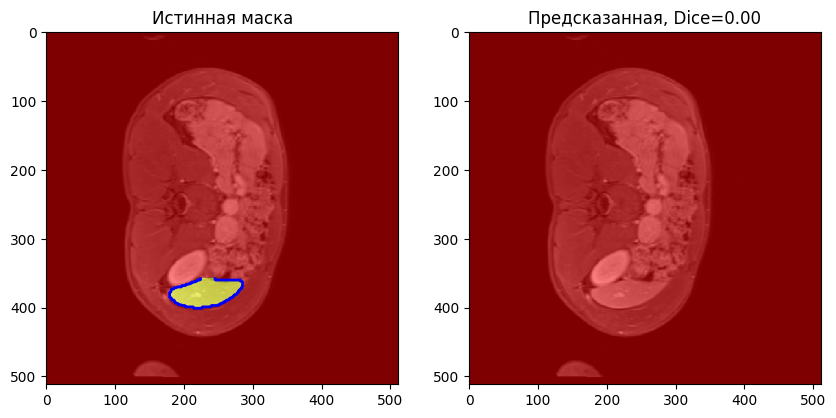

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


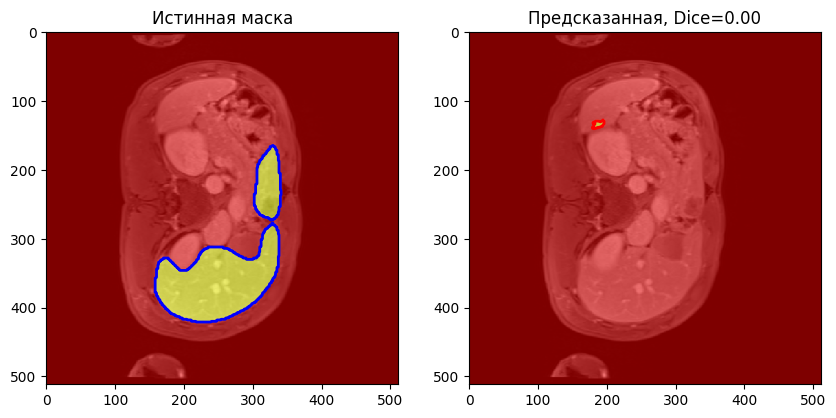

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


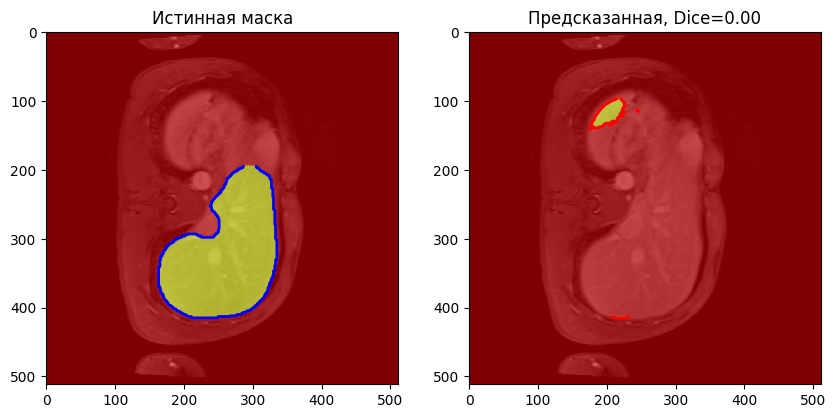

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


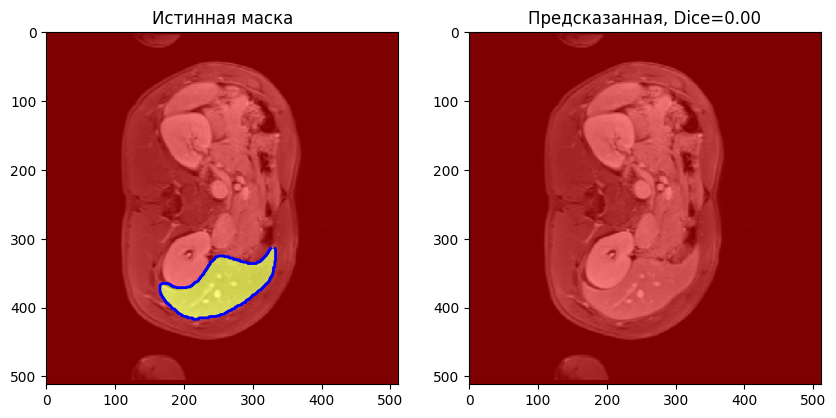

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


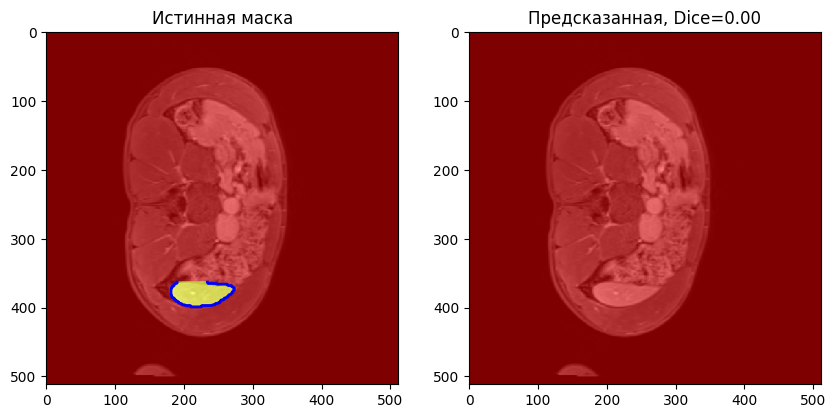

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


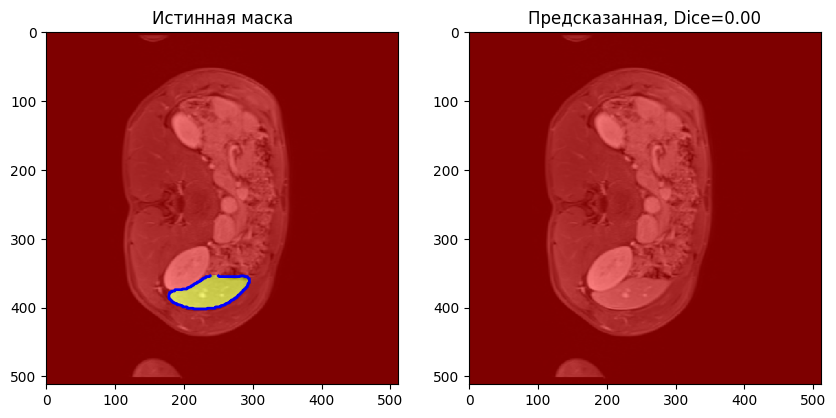

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


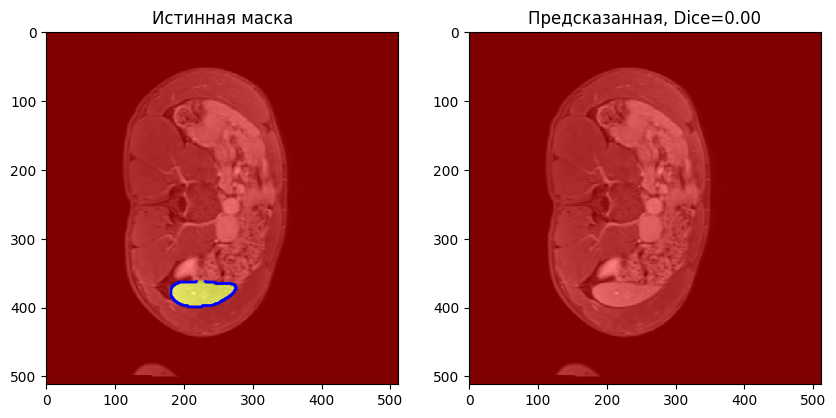

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


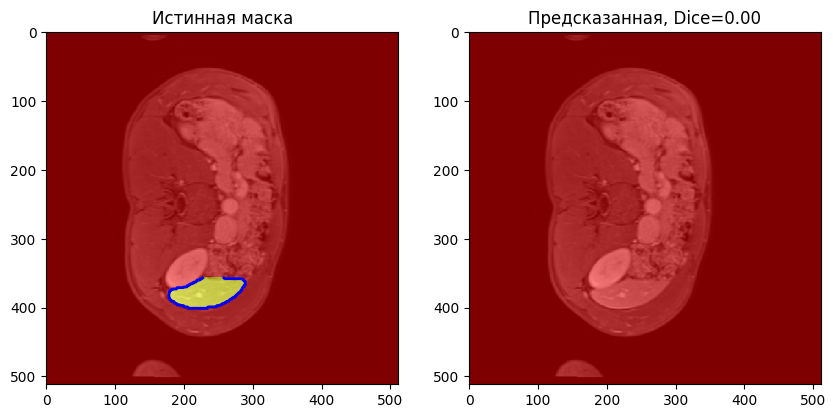

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


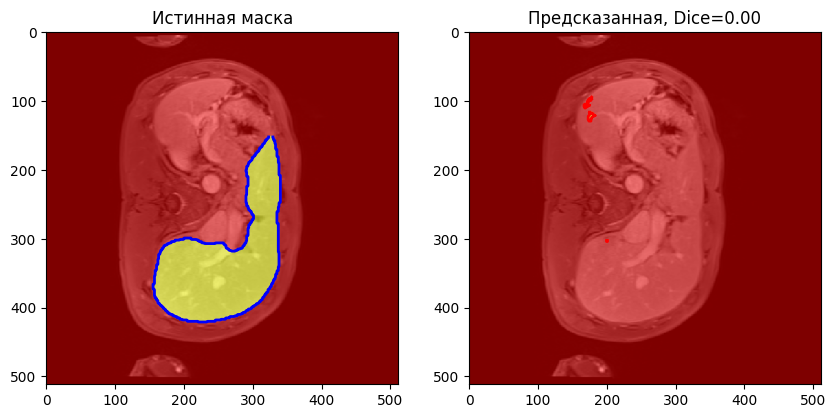

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


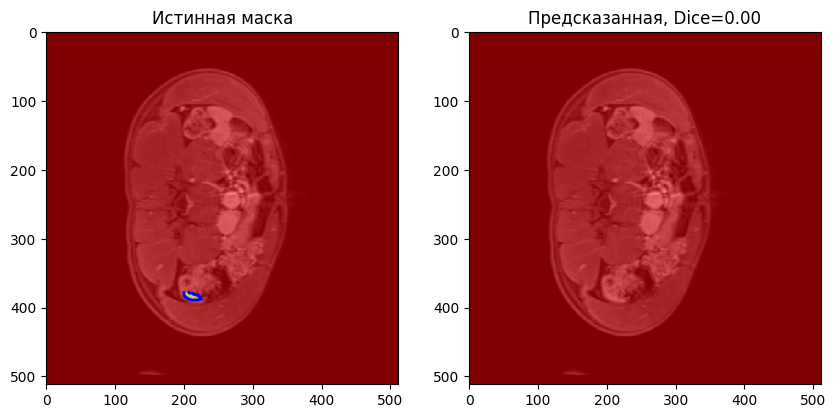

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


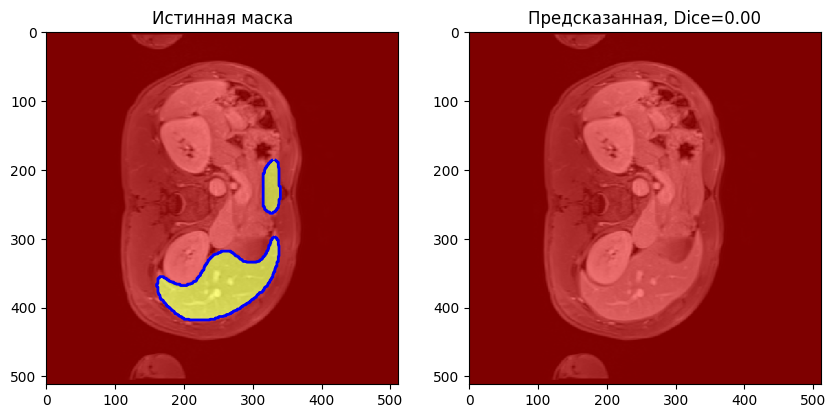

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


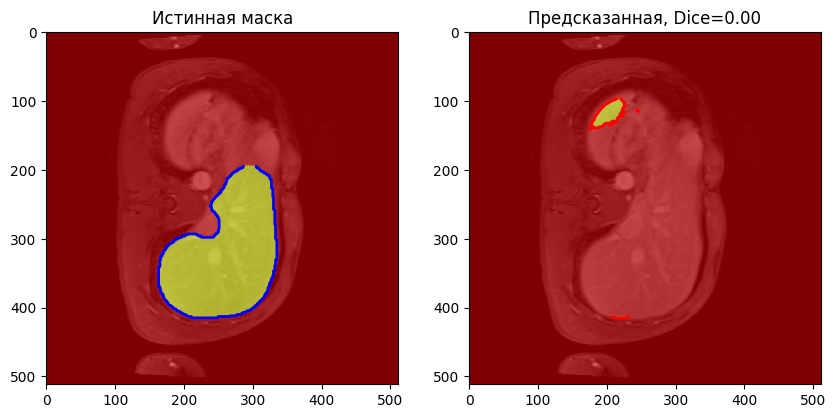

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


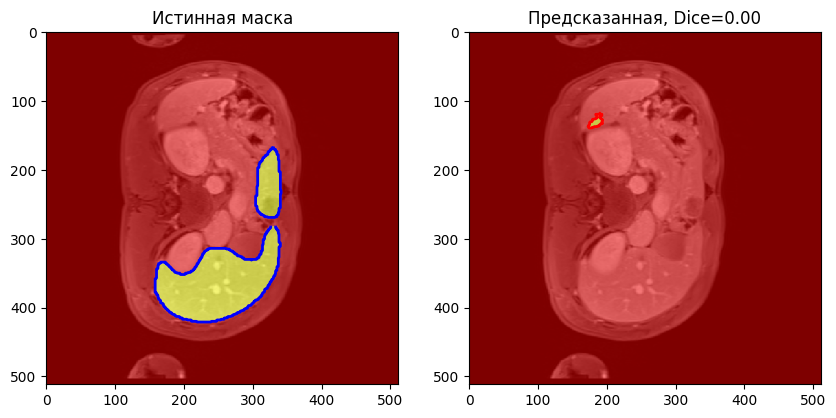

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


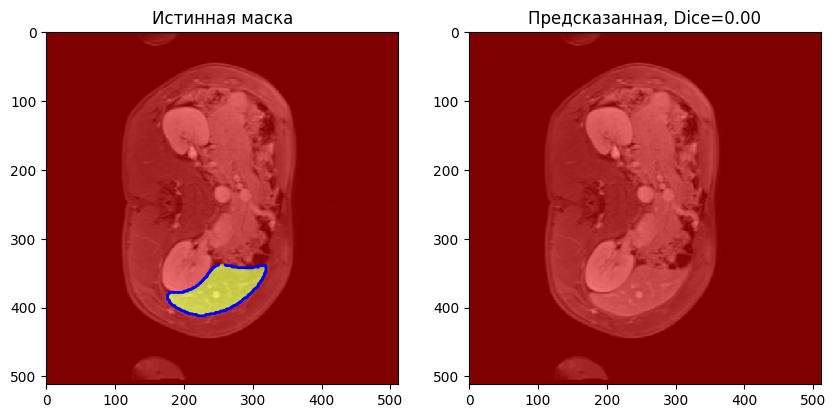

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


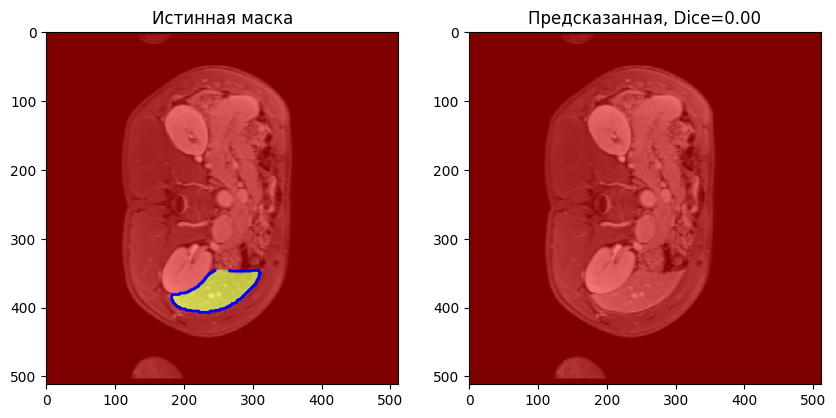

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


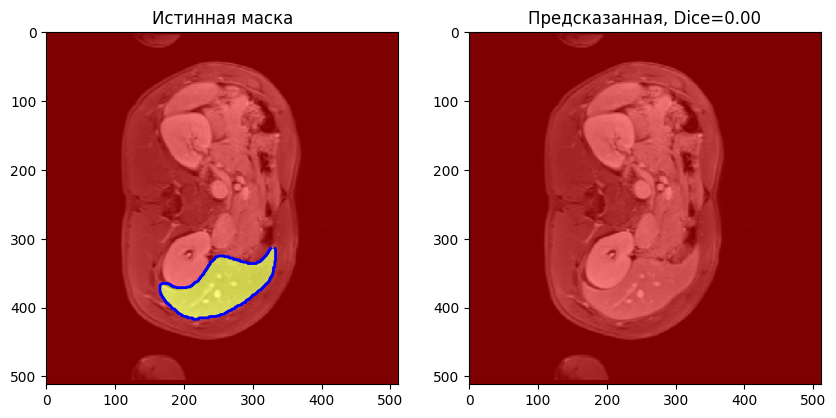

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


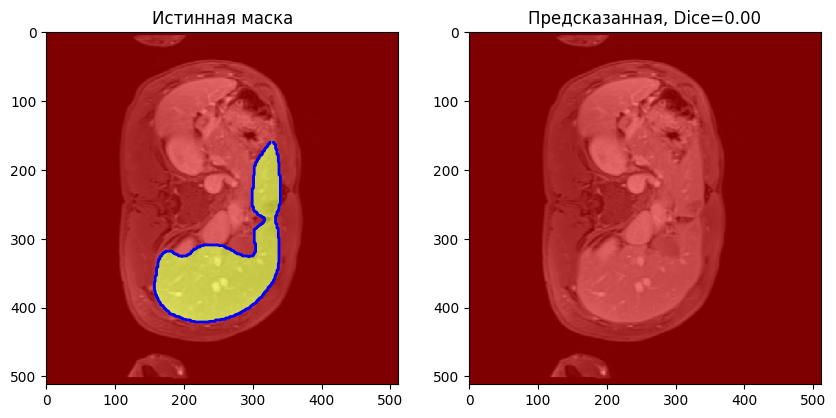

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


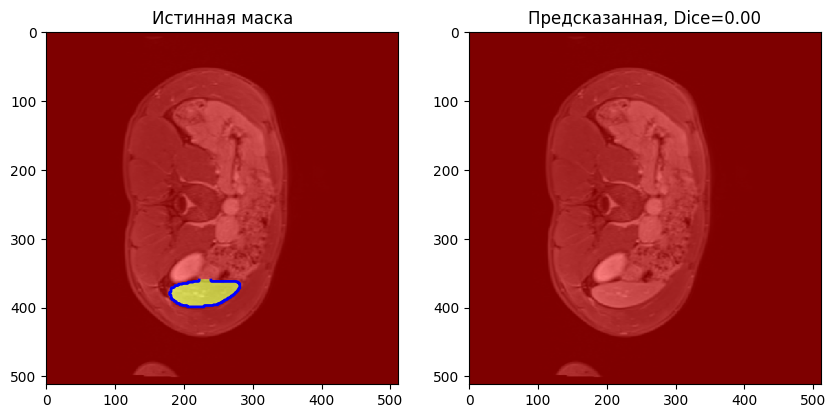

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


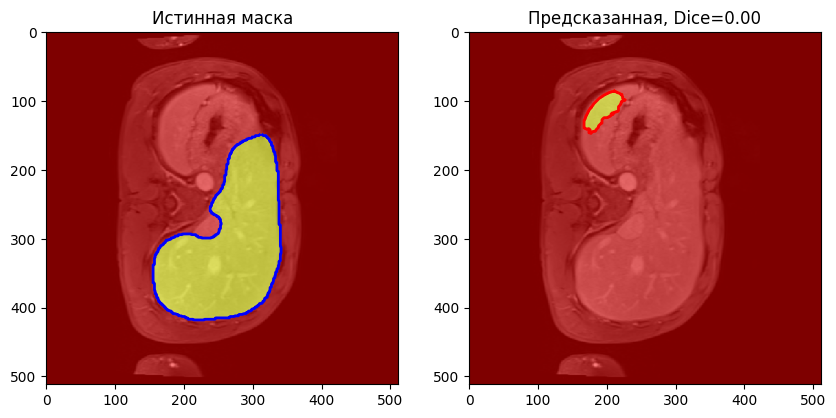

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


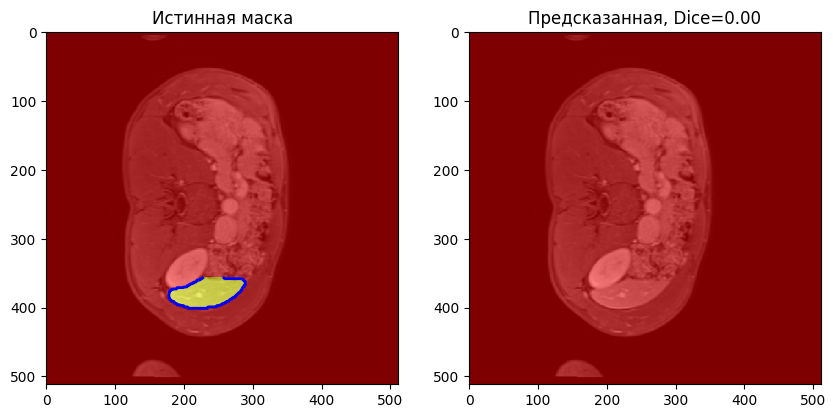

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


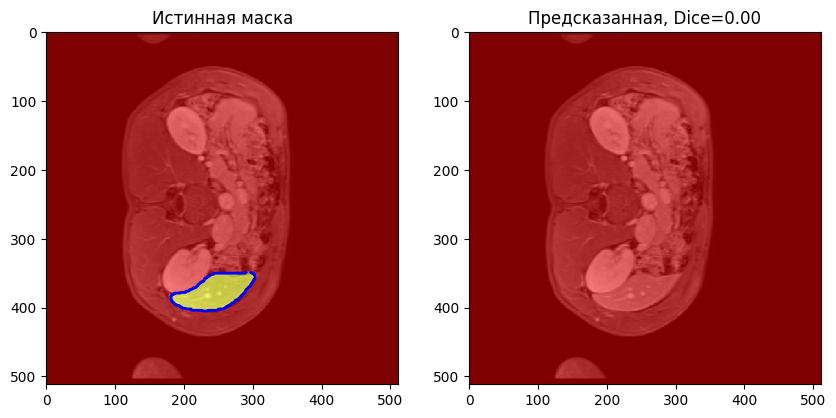

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

(0.0001736499098796067, 8.780441931389944e-05)

In [ ]:
evaluate(X_test, y_test, 'TEST SET', 30)